<a href="https://colab.research.google.com/github/nyp-sit/iti107-2024S2/blob/main/Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install datasets transformers

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00


In [1]:
import os
# import faiss
import torch
import skimage
import requests
# import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

The conceptual captions dataset consists of around 3.3M images with two main columns: the image URL and its caption. You can find more details from the corresponding huggingface link.



In [2]:
# Get the dataset
image_data = load_dataset("conceptual_captions", split="validation[:200]")

In [3]:
image_data

Dataset({
    features: ['image_url', 'caption'],
    num_rows: 200
})

Not all URLs in the dataset are valid. We fix that by testing and removing all erroneous URL entries.

In [4]:
def check_valid_URLs(image_URL):
    try:
        print('checking url', image_URL)
        response = requests.get(image_URL, timeout=(2,2))
        Image.open(BytesIO(response.content))
        return True
    except:
        return False

def get_image(image_URL):
    try:
        print('getting image from ', image_URL)
        response = requests.get(image_URL)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image
    except:
        return None


In [5]:
# convert to dataframe
image_data_df = pd.DataFrame(image_data)

The second step is to download the images from the URLs. This helps us avoid constant web requests.

Image and text embeddings implementation
The prerequisites to successfully implement the encoders are the model, the processor, and the tokenizer.

The following function fulfills those requirements from the model ID and the device used for the computation, either CPU or GPU.

In [6]:
# # Transform dataframe
# image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)
# # Get valid URLs
# image_data_df = image_data_df[image_data_df["is_valid"]==True]
# Get image from URL
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

getting image from  https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg
getting image from  http://www.standard.net/image/2015/02/04/800x_a16-9_b0_q81_p1/winter-fly-fishing.jpg
getting image from  http://indianapolis-photos.funcityfinder.com/files/2009/12/Clearwater-Crossing-Shopping-Center-sign-Indianapolis-Indiana.jpg
getting image from  http://www.abc.net.au/news/image/9066492-3x2-700x467.jpg
getting image from  https://www.featurepics.com/StockImage/20090316/carrying-globe-stock-image-1115085.jpg
getting image from  http://i.dailymail.co.uk/i/pix/2014/11/05/1415187324676_wps_31_Home_is_a_little_Deer_Ivy.jpg
getting image from  http://www.waste360.com/sites/waste360.com/files/styles/article_featured_standard/public/Trista%2002%20007_0.jpg?itok=F1eJZsX3
getting image from  https://media.gettyimages.com/photos/young-woman-seated-on-the-beach-picture-id97545987?s=612x612
getting image from  https://worldjourneysdiscover.files.wordpress.com/201

In [13]:
image_data_df.head()

,image_url,caption,image
0,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,author : a life in photography -- in pictures,<PIL.Image.Image image mode=RGB size=736x736 a...
5,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,the - bedroom stone cottage can sleep people,<PIL.Image.Image image mode=RGB size=634x477 a...
8,https://worldjourneysdiscover.files.wordpress....,party in the park under cherry blossoms,<PIL.Image.Image image mode=RGB size=860x645 a...
11,https://i.pinimg.com/736x/27/d5/94/27d59424cd7...,where 's the best place to show off your nails...,<PIL.Image.Image image mode=RGB size=480x480 a...
12,https://thumb9.shutterstock.com/display_pic_wi...,that combines elements of a simple vegetable a...,<PIL.Image.Image image mode=RGB size=450x470 a...


In [12]:
image_data_df = image_data_df.dropna()

In [10]:
def get_model_info(model_ID, device):
    # Save the model to device
    model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
    processor = CLIPProcessor.from_pretrained(model_ID)
    # Get the tokenizer
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)
    # Return model, processor & tokenizer
    return model, processor, tokenizer

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the model ID
model_ID = "openai/clip-vit-base-patch32"

# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
len(image_data_df)

139

Text embeddings
We start by generating the embedding of a single text before applying the same function across the entire dataset.

In [15]:
def get_single_text_embedding(text):
    inputs = tokenizer(text, return_tensors = "pt")
    text_embeddings = model.get_text_features(**inputs)
    # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

def get_all_text_embeddings(df, text_col):
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
    return df

# Apply the functions to the dataset
image_data_df = get_all_text_embeddings(image_data_df, "caption")

The same process is used for image embeddings but with different functions.

In [19]:
def get_single_image_embedding(my_image):
    image = processor(
		text = None,
		images = my_image,
		return_tensors="pt"
		)["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

def get_all_images_embedding(df, img_column):
	df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
	return df

image_data_df = get_all_images_embedding(image_data_df, "image")

In [20]:
image_data_df.head()

,image_url,caption,image,text_embeddings,img_embeddings
0,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,author : a life in photography -- in pictures,<PIL.Image.Image image mode=RGB size=736x736 a...,"[[0.25595313, 0.017629517, -0.07823522, 0.2005...","[[0.040990446, -0.10438324, -0.31445798, 0.129..."
5,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,the - bedroom stone cottage can sleep people,<PIL.Image.Image image mode=RGB size=634x477 a...,"[[0.20380998, 0.053177867, -0.034089975, 0.015...","[[-0.24235836, 0.07684165, 0.083442815, 0.2379..."
8,https://worldjourneysdiscover.files.wordpress....,party in the park under cherry blossoms,<PIL.Image.Image image mode=RGB size=860x645 a...,"[[-0.02903319, 0.005893377, 0.03012573, -0.150...","[[-0.00015183564, 0.15472421, -0.16761929, 0.1..."
11,https://i.pinimg.com/736x/27/d5/94/27d59424cd7...,where 's the best place to show off your nails...,<PIL.Image.Image image mode=RGB size=480x480 a...,"[[-0.47875932, 0.08501654, -0.11941216, -0.138...","[[-0.82128143, -0.530651, 0.35973275, 0.707048..."
12,https://thumb9.shutterstock.com/display_pic_wi...,that combines elements of a simple vegetable a...,<PIL.Image.Image image mode=RGB size=450x470 a...,"[[-0.1046481, 0.2848672, 0.474755, -0.03007175...","[[-0.055025034, -0.28183487, 0.16542053, 0.362..."


The helper function get_top_N_images generates similar images for the two scenarios illustrated in the workflow above: text-to-image search or image-to-image search.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_N_images(query, data, top_K=4, search_criterion="text"):
    # Text to image Search
    if(search_criterion.lower() == "text"):
        query_vect = get_single_text_embedding(query)
    # Image to image Search
    else:
        query_vect = get_single_image_embedding(query)
    # Relevant columns
    revevant_cols = ["caption", "image", "cos_sim"]
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))# line 17
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    """
    Retrieve top_K (4 is default value) articles similar to the query
    """
    most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[1:top_K+1] # line 24
    return most_similar_articles[revevant_cols].reset_index()

Let’s understand how we perform the recommendation.

→ The user provides either a text or an image as a search criterion, but the model performs a text-to-image search by default.

→ In line 17, a cosine similarity is performed between each image vector and the user’s input vector.

→ Finally, in line 24, sort the result based on the similarity score in descending order, and we return the most similar images by excluding the first one corresponding to the query itself.

Example of searches
This helper function makes it easy to have a side-by-side visualization of the recommended images. Each image will have the corresponding caption and similarity score.



In [22]:
def plot_images_by_side(top_images):
    index_values = list(top_images.index.values)
    list_images = [top_images.iloc[idx].image for idx in index_values]
    list_captions = [top_images.iloc[idx].caption for idx in index_values]
    similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]
    n_row = n_col = 2
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
        ax.imshow(img)
        sim_score = 100*float("{:.2f}".format(sim_score))
        ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
    plt.show()

Text-to-image
→ First, the user provides the text that is used for the search.

→ Second, we run a similarity search.

→ Third, we plot the images recommended by the algorithm.

Query: lying on a cozy bed


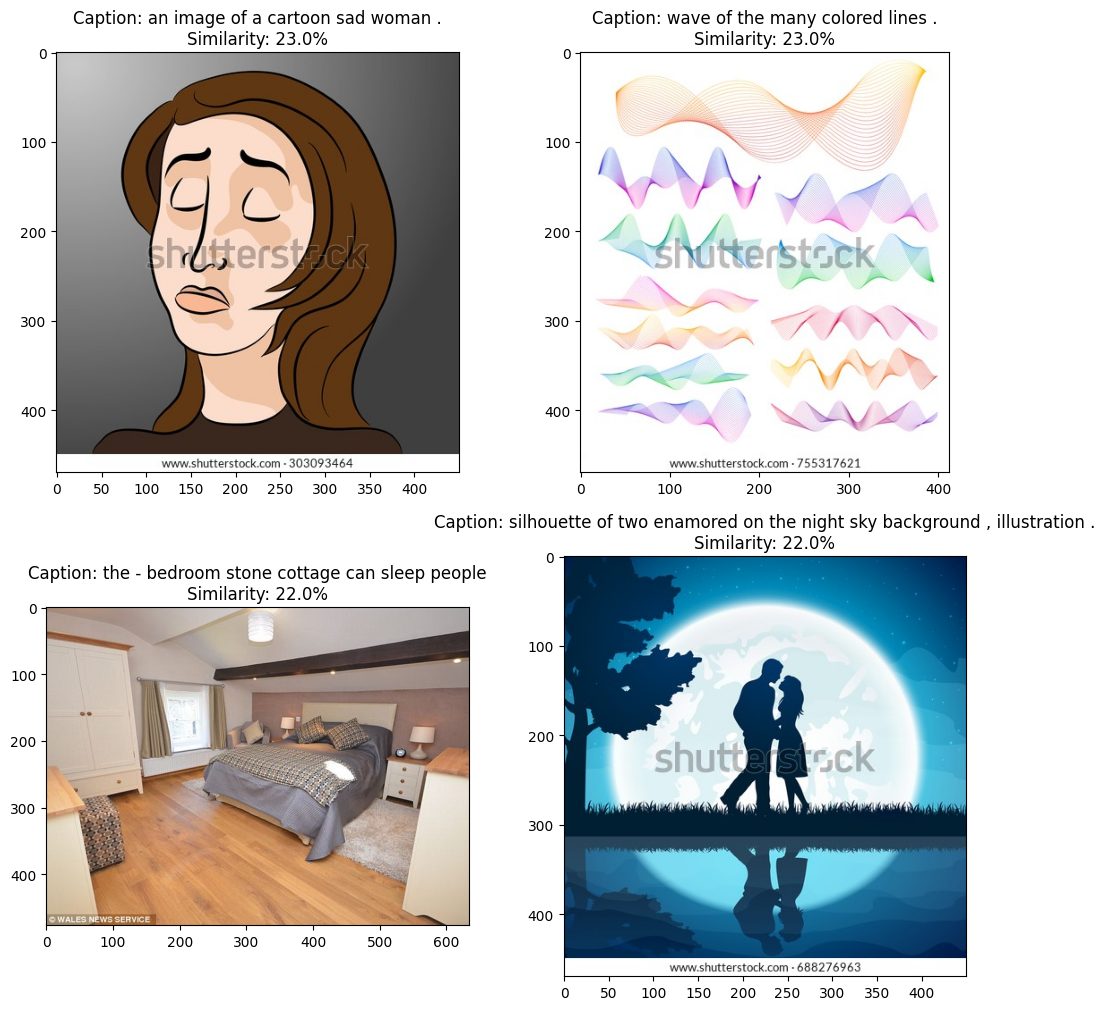

In [35]:
query_caption = image_data_df.iloc[10].caption
query_caption = 'lying on a cozy bed'
# Print the original query text
print("Query: {}".format(query_caption))
# Run the similarity search
top_images = get_top_N_images(query_caption, image_data_df)
# Plot the recommended images
plot_images_by_side(top_images)

## Image-to-image
The same process applies. The only difference this time is that the user provides an image instead of a caption.

In [29]:
type(query_image)

PIL.Image.Image

In [42]:
query_image = Image.open('toothpaste.webp')

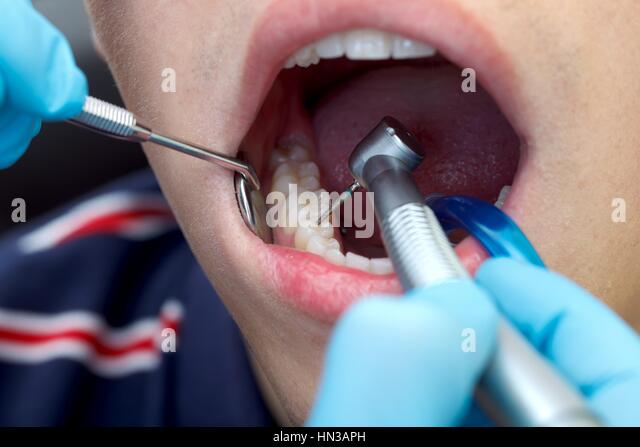

In [41]:
# Get the query image and show it
query_image = image_data_df.iloc[10].image
query_image

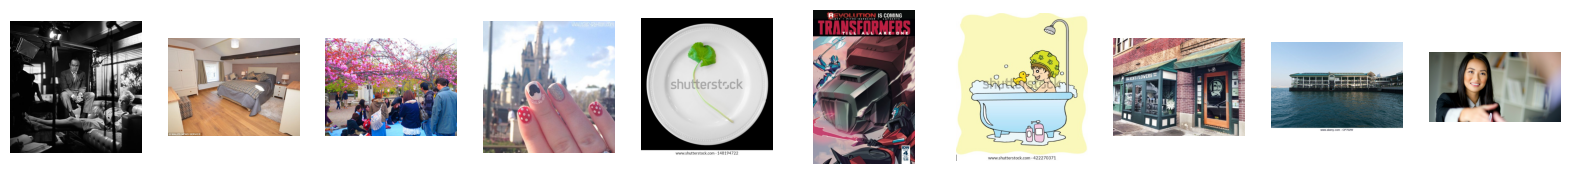

In [38]:
# prompt: from image_data_df plot the first 10 images into subplots of 1 row 10 columns

import matplotlib.pyplot as plt

# Get the first 10 images
images_to_plot = image_data_df["image"].iloc[:10].tolist()

# Create a figure and axes
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

# Iterate through the images and plot them
for i, image in enumerate(images_to_plot):
    axs[i].imshow(image)
    axs[i].axis('off')

plt.show()


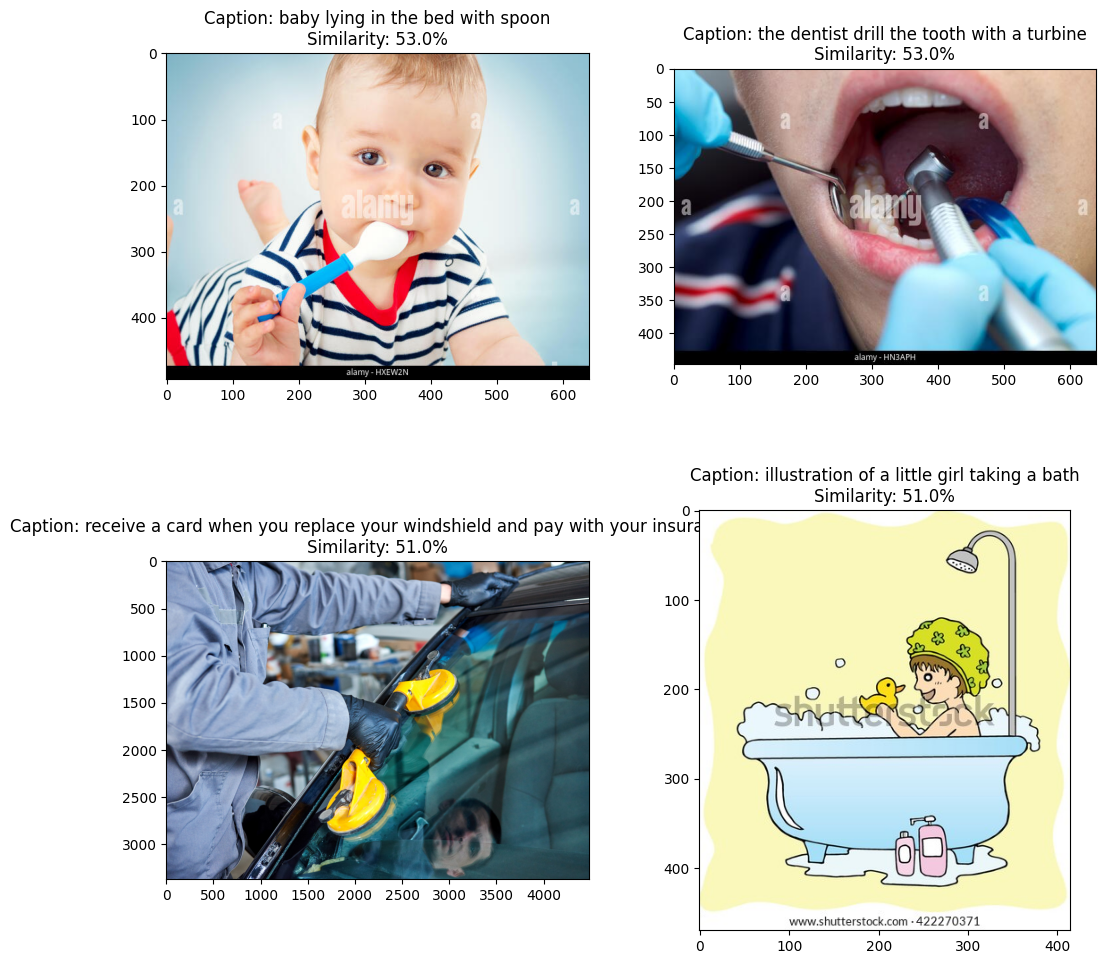

In [43]:
# Run the similarity search and plot the result
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
# Plot the result
plot_images_by_side(top_images)